The initial code is specifying details abou the authors and then providing information on the pipeline purpose

In [ ]:
#!/usr/bin/python
__author__		= "Sander Granneman"
__copyright__	= "Copyright 2020"
__version__		= "0.7.0"
__credits__		= ["Sander Granneman", "Edward Wallace"]
__email__		= ["sgrannem@staffmail.ed.ac.uk", "edward.wallace@ed.ac.uk"]
__status__		= "beta"

""" CRAC_pipeline_SE_demult_dedup.py

This is a pipeline for processing single-end multiplexed CRAC sequencing data.
It is forked from CRAC_pipeline_SE.py v0.6.0, also written in ruffus.
This pipeline is specialised for single-end data that is multiplexed in-line, so
requires trimming of 3' adapters and demultiplexing, including deduplication. This 
simplifies the logic of the pipeline, no conditional execution needed.

"""

This section just imports relevant tools to run the pipeline, including from rufus

In [ ]:
from ruffus import *
from ruffus.cmdline import MESSAGE
from collections import defaultdict
import ruffus.cmdline as cmdline
import subprocess
import platform
import glob
import re
import os
import argparse
import sys
import time

This defines the fields of interest that exist in the GFF file, which will allow this informaton to be called later. The general file format (GFF) is used for numerous inputs in 'input_annotation' - inc mRNA transcript locations mapped to the genome, transcript annotations with ncRNAs and mRNAs broken down into parts (UTR, ORF etc) and a set of annotations of transcript features. 

In [ ]:
GFF_FIELDS = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attributes"]

Data parsing is a method to strucute data, it takes input data (in human friendly file forms) and breaks it into small segments more usable by computers, often organised in a parse tree. It is a processing library for arguments that are added. 

Supported actions include storing the argument (singly, or as part of a list), storing a constant value when the argument is encountered (including special handling for true/false values for boolean switches)and counting the number of times an argument is seen.

Arguments here are:
* The paths to .fastq files, paths to the gff files of annotations, to the chromosome file and the novoalign file (this is everything to aline reads to the genome)
* Path to the barcodes file needed for demultiplexing, file of the 3' adapter sequences for trimming, an input variable of the number of mismatches allowed for demultiplexing and how many processors you want to use for this.
* The path to a genelist file for pile up analysis and a genome sequence file to use for this.
* The gff file containing transcript sequences for count anlaysis.

In [ ]:
parser = cmdline.get_argparse(description="CRAC pipeline for processing single-end multiplexed CRAC data")
parser.add_argument("-f",dest="forwardreads",help="the path to your fastq read files.",metavar="data_1.fastq data_2.fastq ...",nargs="*",default=None)
parser.add_argument("-g","--gtf",dest="gtf",help="the path to your gtf annotation file",metavar="rRNA.gtf",default=None)
parser.add_argument("-c","--chromosome",dest="chromosome",help="the path to your chromosome length file",metavar="chromosome_lengths.txt",default=None)
parser.add_argument("--novoindex",dest="novoindex",help="the path to your novoindex file",metavar="yeast.novoindex",default=None)
parser.add_argument("--name",dest="name",help="provide a single word describing the run. Default is 'analysis' with a time stamp",default="analysis_%s" % time.strftime("%d%m%Y"))
parser.add_argument("--sgr",dest="sgr",help="to make sgr files with read counts for each genomic position. Default is off",action="store_true",default=False)
parser.add_argument("-b","--barcodes",dest="barcodes",help="the path to the file containing the list of barcodes. If you do not provide a barcode file, the demultiplexing step will fail",metavar="barcodes.txt",default=None)
parser.add_argument("-a","--adapterfile",dest="adapterfile",help="file containing the 3' adapter sequences for trimming the reads using flexbar. If you do not provide adapter file or preset",default=None)
parser.add_argument("-aa","--adapterpreset",dest="adapterpreset",help="adapter preset string [TruSeq, SmallRNA, Methyl, Ribo, Nextera, and NexteraMP]. Requires Flexbar version 3.4.0 or later.",default=None)
parser.add_argument("-m","--mismatches",dest="mismatches",type=int,help="indicate how many mismatches you allow for demultiplexing. Default is 1",default=1)
parser.add_argument("-p","--processors",dest="processors",type=int,help="indicate how many processors you want to use for analyses. Default is 8",default=8)
parser.add_argument("--genelist",dest="genelist",help="provide a genelist file for pileup analysis, with one gene name per line,",default=None)
parser.add_argument("--genometab",dest="genometab",help="provide a genome sequence file in pyCRAC tab format for pileup analysis",default=None)
parser.add_argument("--transcriptgff",dest="transcriptgff",help="provide a gff file containing only transcript sequences for count analysis",default=None)
args = parser.parse_args()

In python to define a function the syntax is __def__ function name(parameters): and then on a new line a defintion of the function so the below creates the function getBarcodeInfo that operates on the input parameter BarcodeInfo

This set of code is used to define all the functions to be used in the pipeline - these functions can then be provided to rufus alongside their connection and the programme will direct data correctly through this

In [ ]:
#this is a function to return the .fastq barcode file in the desired format
def getBarcodeInfo(barcodefile):
	return ["%s.fastq" % "_".join(line.strip().split()) for line in open(barcodefile,"r").readlines()]
	

The program Flexbar preprocesses high-throughput sequencing data efficiently. It demultiplexes barcoded runs and removes adapter sequences - it is available on GitHub

A command line interpreter allows the user to interact with a program using commands in the form of text lines - users can type their requests and queries as required and obtain the desired results. cmd is a module to provide the line oriented interpreter framework.

The os module provides a portable way of using operating system dependent functionality, this is a program that acts as an interface between the system hardware and the user.

NOTE: These functions now all specify inputfile as the input, and outputfile as the output which allows them all to be linked to one another as a file ouput from the first can move into the next.

In [ ]:
#This function defines the input,runs Flexbar on this and defines and output format to remove adapter sequences
#qflags is a kind of enum, a data type consisting of a set of named values called elements. 
#The QFlags class provides a type-safe way of storing OR-combinations of enum values

def runFlexBar(inputfile,outputfile,qflags = "-q TAIL -qf i1.8 -qt 30 --qtrim-post-removal"):
	""" runs Flexbar on the data to remove the adapter sequence from the forward reads """
	if args.adapterfile:
		cmd = "flexbar -r '%s' --output-reads '%s' -n 10 %s -ao 5 --adapters '%s'" % (inputfile,outputfile,qflags,args.adapterfile)
	elif args.adapterpreset:
		cmd = "flexbar -r '%s' --output-reads '%s' -n 10 '%s' -ao 5 -aa '%s'" % (inputfile,outputfile,qflags,args.adapterpreset)
	else:
		cmd = "flexbar -r '%s' --output-reads '%s' -n 10 '%s' -ao 5" % (inputfile,outputfile,qflags)
	logger.info(cmd)
	os.system(cmd)

pyBarcodeFilter.py is one of the codes provided in the pyCRAC software - The tool looks for barcodes in 5' ends of reads and generates separate data files for each barcode in a minimal FASTQ format. Once the tool identies a barcode, the barcode sequence and corresponding quality characters are removed from the raw data and placed in a separate output file.

In [ ]:
#this function used the Barcodefilter tool to demultiplex the input .fastq file with all the raw reads
#notice here that -f, -b, -m etc are arguments specified in the parsing at the beginning, so rufus can call what to use for the command
def demultiplexSamples(inputfile,outputfile):
	""" demultiplexes all the samples """
	os.chdir(os.path.join(root_dir,"demultiplexed"))
	cmd = "pyBarcodeFilter.py -f '%s' -b '%s' -m '%s'" % (inputfile,os.path.join(home_dir,args.barcodes),args.mismatches)
	logger.info(cmd)
	os.system(cmd)
	os.chdir(root_dir)

During demultiplexing, pyBarcodeFilter will attach the two hashes and random barcode sequence to the read header. pyFastqDuplicateRemover scans the header for the presence of two hashes near the end and assumes that the sequence following these hashes is the random barcode sequence. If it encounters two identical (paired-) sequences with the same random barcode sequences, it assumes they are PCR duplicates and collapse them into one sequence. Produces a fasta output file

e.g FCC0TU2ACXX:4:1101:1968:2135#ACAGTGAT1##GTTCTC

In [ ]:
def collapseDuplicates(inputfile,outputfile):
	""" Removes the last random nucleotide from the forward read, collapses the data and then splits it again into fasta files """
	cmd = "pyFastqDuplicateRemover.py -f '%s' -o '%s'" % (inputfile,outputfile)
	logger.info(cmd)
	os.system(cmd)
	

Novoalign runs as a package in python, it is an alignment tool for Illumina reads and accurately maps reads to a reference genome.
* -d specifies the reference genome for novoalign
* -o specifies the output format
* -f was specified as the forward reads in parsing
* -r sets the rules for handling of reads with multiple alignment locations, Random mode will randomly chose a single alignment location from amongst all the alignment results.

In [ ]:
def alignReads(inputfile,outputfile,alignfiletype = "SAM"):
	""" Runs novoalign on all the collapsed files"""
	cmd = "novoalign -d '%s' -o '%s' -f '%s' -r Random > '%s'" % (args.novoindex,alignfiletype,inputfile,outputfile)
	logger.info(cmd)
	os.system(cmd)

After aligning the reads to the reference genome the  rst thing we routinely do is generate hit tables describing the number of reads that mapped to genes or transcripts and to which features they were mapped. The pyReadCounters program takes the Novoalign or BAM/SAM file and asks which reads overlap with genomic features from a GTF file. This produces three outputs: 
* (1) A text file containing information about the complexity of the sequencing data
* (2) a GTF file containing all the genomic mapping positions of cDNA sequences and overlapping genomic features (both sense and anti -sense)
* (3) a hit table text file that shows for each genomic feature the number of intervals that mapped sense or anti -sense.

In [ ]:
def runPyReadCounters(inputfile,outputfile,alignfiletype="sam"):
	""" runs pyReadCounters on all the files """
	outputfile = re.search("(.*)_count_output_reads.gtf",outputfile).group(1)
	cmd = "pyReadCounters.py -f '%s' --gtf '%s' -v --rpkm -o '%s' --file_type='%s' " % (inputfile,args.gtf,outputfile,alignfiletype)
	logger.info(cmd)
	os.system(cmd)
	

In [ ]:
#here the program is asking pyReadCounters to not track any mutations (it can track only deletions/or specific mutations)
#the --blocks option states reads with the same start and end coordinates on a chromosome will be counted as one
def runPyReadCountersBlocksNoMuts(inputfile,outputfile,alignfiletype="sam"):
	""" runs pyReadCounters on all the files with options --mutations  nomuts --blocks """
	outputfile = re.search("(.*)_count_output_cDNAs.gtf",outputfile).group(1)
	cmd = "pyReadCounters.py -f '%s' --gtf '%s' -v --rpkm -o '%s' --file_type='%s' --mutations  nomuts --blocks" % (inputfile,args.gtf,outputfile,alignfiletype)
	logger.info(cmd)
	os.system(cmd)
	

pyGTFsgr is a tool that produces sgr files from cluster, motif or interval GTF files and these can be loaded into the genome browsers to visualise read distribution over the genome. 
Inputs:
* a GTF file with intervals
* tab-delimited file containing information about the length of each chromosome (this is -c in the parser and refered to in the code)
The --zeros flag asks for chromsomal positions without any covergae to still be reported
By default, the script assumes that each interval is unique and ignores the number of identical reads reported by pyReadCounters. The --count flag asks to include duplicate reads

In [ ]:
def makeCoverageSgrFiles(inputfile,outputfiles):
	""" takes the pyReadCounters gtf output files and generates coverage sgr files """
	outputfile = re.search("(.*)_plus.sgr",outputfiles[0]).group(1)
	cmd = "pyGTF2sgr.py --gtf '%s' --zeros --count -v -o '%s' -c '%s'" % (inputfile,outputfile,args.chromosome)
	logger.info(cmd)
	os.system(cmd)
		

BedGraph is a file format that allows display of continuous-valued data in a track in genome browsers
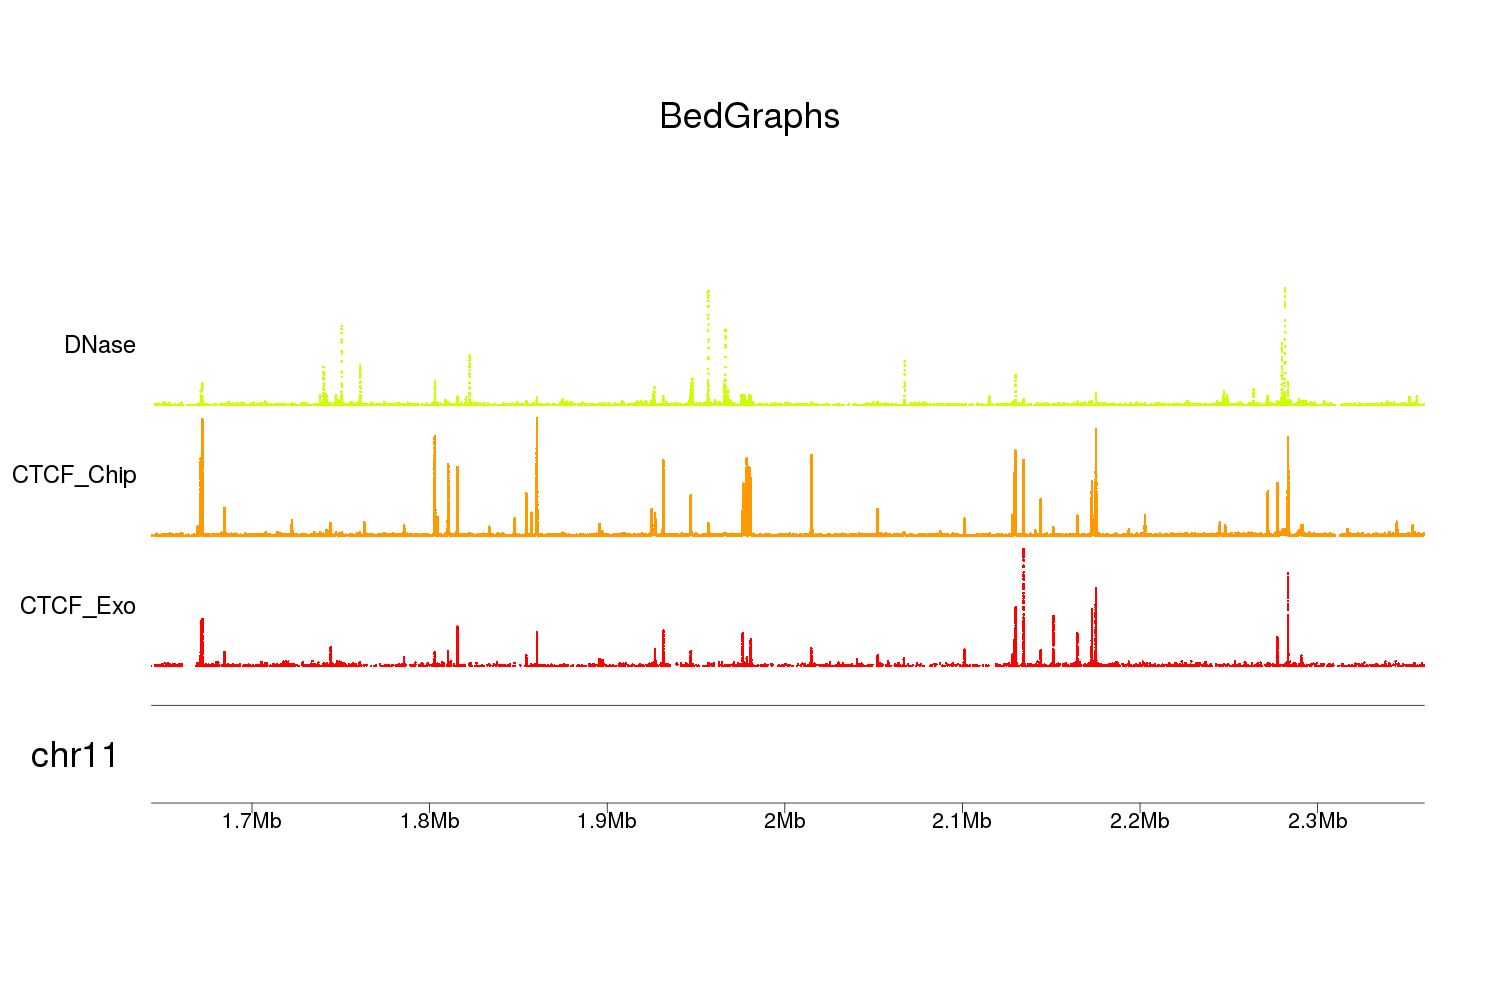
pyGFT2bedGraph is the pyCRAC tool to generate bedgraphs. Inputs are the same as for the GTF2sgr, as it is a variation in the output of the same data.
Parameters:
* The --count flag instructs to include all reads (inc duplicates)
* The --permillion flag instructs to normalise hits per million (the GTF file must contain the total number of mapped reads)

In [ ]:
def makeCoverageBedgraphFiles(inputfile,outputfiles):
	""" takes the pyReadCounters gtf output files and generates bedgraph files for viewing of the data in genome browsers """
	outputfile = re.search("(.*)_plus.bedgraph",outputfiles[0]).group(1)
	cmd = "pyGTF2bedGraph.py --gtf '%s' --count -v --permillion -o '%s' -c '%s'" % (inputfile,outputfile,args.chromosome)
	logger.info(cmd)
	os.system(cmd)

Assessing the background level by negative controls is often not possible. An FDR algorithm can be used to indicate that the probability that the region being considered is not significantly enriched (i.e false positive).
Input files: 
* (1) a pyReadCounters GTF output file
* (2) a GTF annotation file
* (3) a tab delimited file containing chromosome names and chromosome lengths.
For each feature in the GTF annotation file it calculates the minimum number of over-lapping reads required to obtain an FDR less than or equal to the set threshold and reports genomic intervals with at least this read coverage in the GTF output file.
Here they specify they only want to see peaks with suitable FDRs on protein-coding genes

In [ ]:
def runPyCalculateFDRs(inputfile,outputfile):
	""" runs pyCalculateFDRs.py to find peaks with false discovery rates, on protein-coding genes """
	cmd = "pyCalculateFDRs.py -f '%s' -o '%s' -c '%s' --gtf '%s' -a protein_coding -m 0.01 --min=5 " % (inputfile,outputfile,args.chromosome, args.gtf)
	logger.info(cmd)
	os.system(cmd)

The genome browser is a very useful tool to visualise read distribution on chromosomes; however, often it is more convenient to generate separate pileup files for individual genes or chromosomal regions.
input files: 
* (1) file containing the mapping data (-f option)
* (2) a GTF feature file (- -gtf flag),
* (3) a genomic reference sequence file in the tab format (--tab)
* (4) a text file containing information about the genes/-transcripts of interest (-g).
The code here will produce an output file for the provided genes (-g) that contains six columns in which each line consists of the gene or feature name, the 1-based coordinate, the reference base, the number of reads that cover that base, the number of times the reference base was substituted in reads and the number of times the reference base was deleted in reads.

In [ ]:
def runPyPileup(inputfile,outputfile,alignfiletype = "sam"):
	""" runs pyPileup.py to make pileup tables of reads and deletions/mutations for a given genelist """
	cmd = "pyPileup.py -f '%s' -o '%s' --tab '%s' --gtf '%s' --file_type='%s' -g '%s'" % (inputfile,outputfile,args.genometab, args.gtf, alignfiletype, args.genelist)
	logger.info(cmd)
	os.system(cmd)
	

Given a file with aligned sequencing reads and a list of genomic features, a common task is to count how many reads map to each feature (a feature is here an interval, i.e.a range of positions, on a chromosome). In the case of RNA-Seq, the features are typically genes and each gene is considered as the union of all its exons. 

__The script htseq-count is a tool for RNA-Seq data analysis: Given a SAM/BAM file and a GTF or GFF file with gene models, it counts for each gene how many aligned reads overlap its exons.__

In [ ]:
def runHTSeqCountTranscripts(inputfile,outputfile,minaqual=2):
	""" runs htseq-count to assign reads to primary transcript features """
	# Note: this did not play well with novoalign reads, so not being run for now.
	cmd = "htseq-count -n 8 -a '%s' --counts_output '%s' '%s' '%s'  " % (minaqual, outputfile, inputfile, args.gtf)
	logger.info(cmd)
	os.system(cmd)

sort commands can be used to structure files (usually alphabeticaly) in a way that makes sense to the user. This function is organising and compressing .SAM files (generated in the pipeline) to .BAM format

In [ ]:
def sortBamFiles(inputfile,outputfile):
	""" sorts .sam file, to produce a sorted compressed .bam """
	outputfile = outputfile
	cmdsort = "samtools view -b '%s' | samtools sort -@ 3 -O bam -o '%s' -T '%s'/tmp - " % (inputfile, outputfile, root_dir)
	logger.info(cmdsort)
	os.system(cmdsort)

The .sam files have now been compressed to the binary format .bam, a binary 'blob' that stores all of your aligned sequence data. Bam files can have a companion file, called an index file. This file has the same name, suffixed with .bai. This file acts like an external table of contents, and allows programs to jump directly to specific parts of the bam file without reading through all of the sequences. The below function acts to produce these, meaning an easily used library for the algorithm can be made.

In [ ]:
def indexBamFiles(inputfile,outputfile):
	""" indexes a sorted .bam file, to produce a matching .bam.bai """
	cmdindex = "samtools index '%s' " % (inputfile)
	logger.info(cmdindex)
	os.system(cmdindex)

FastQC is a quality control tool for high throughput sequence data - provides a set of modular reports that you can use to assess if your data has any problems before you use it. Supports import of data from .BAM, .SAM and fastq files. Equally, BamQC is an application which takes a BAM file containing mapped data and runs a series of tests on it to generate a comprehensive QC report - judged on how far it departs from what you'd expect from a normal large data set with no significant biases.

In [ ]:
def runFastQC(inputfile,outputfile):
	""" runs fastQC on input fastq file """
	outputdir = os.path.split(outputfile)[0]
	cmd = "fastqc -o '%s' '%s'" % (outputdir, inputfile)
	logger.info(cmd)
	os.system(cmd)

def runBamQC(inputfile,outputfile):
	""" runs BamQC on input bam/sam file """
	outputdir = os.path.split(outputfile)[0]
	cmd = "bamqc -o '%s' '%s'" % (outputdir, inputfile)
	logger.info(cmd)
	os.system(cmd)

* BED files are a text file format used to store genomic regions as coordinates and associated annotations.
bedtools multicov is a tool that reports the count (how many) of alignments in multiple indexed BAM (bai)files that are overlapping the intervals in a BED file. Specifically, for each BED interval provided, it reports a separate count of overlapping alignments from each BAM file.

The early part of the code for this function is (I think) setting out the indexed BAM files to use the cmd= term calls multiBamCov, -s means require same strandedness (only report hits in B that overlap A on the same strand), -bed specifies the BED file with the region to be considered, -bams species the BAM files created above should be used.

In [ ]:
def runMultiCovTranscript(inputfiles,outputfile):
	""" counts reads to transcript features with bedtools multiBamCov """
	inputfileorder = ' '.join(inputfiles)
	inputfilebasenames = [ os.path.basename(f) for f in inputfiles ] 
	logger.info("multiBamCov file order is %s" % ' '.join(inputfilebasenames))
	with open(outputfile, "w") as outhandle:
		outhandle.write( "# allsample_transcriptcounts.txt - counts to transcripts from multiBamCov\n")
		outhandle.write( "# Run from CRAC_pipeline_SE_demult_dedup.py\n")
		outhandle.write( "# %s, date %s\n" % (args.name, time.strftime("%d-%m-%Y")))
		outhandle.write( "%s\n" % '\t'.join(GFF_FIELDS + inputfilebasenames))
	cmd = "multiBamCov -s -bed '%s' -bams %s >> '%s'" % (args.transcriptgff, inputfileorder, outputfile)
	logger.info(cmd)
	os.system(cmd)

bedtools genomecov is a tool that produces summaries of feature coverage (e.g., aligned sequences) for a given genome. This includes in the bedGraph format, which allows display of continuous-valued data in track format as shades of colour/bars of varying height along the genome (see above).

The cmd lines:
* specify the genomeCoverageBed program
* -bg asks the programe to report depth in BedGraph format (as histogram is the default)
* -strand means calculate coverage of intervals from a specific strand (specified as + or -)
* -ibam is the BAM file used as input for coverage

In [ ]:
def makeGenomeCoverageBedgraph(inputfile,outputfiles):
	""" takes the sorted indexed bam files and generates bedgraph files for viewing of the data in genome browsers """
	outputfile = re.search("(.*)_plus.bedgraph",outputfiles[0]).group(1)
	cmdplus = "genomeCoverageBed -bg -strand + -ibam %s > %s" % (inputfile,outputfiles[0])
	logger.info(cmdplus)
	os.system(cmdplus)
	cmdminus = "genomeCoverageBed -bg -strand - -ibam %s > %s" % (inputfile,outputfiles[1])
	logger.info(cmdminus)
	os.system(cmdminus)

To run the pipelune all of the dependent programs (including all of the pyCRAC tools used in functions above) must be installed. This function checks all of the required programs are installed.

In [ ]:
### checking if dependencies are installed

dependencies = ["flexbar","pyGTF2sgr.py","pyGTF2bedGraph.py","pyReadCounters.py","pyBarcodeFilter.py","pyFastqJoiner.py","pyFastqSplitter.py","novoalign","pyFastqDuplicateRemover.py","samtools","fastqc","bamqc","multiBamCov"]

for i in dependencies:
	cmd = "where" if platform.system() == "Windows" else "which"
	try: 
		subprocess.call([cmd, "%s"])
	except: 
		sys.stderr.write("%s is not installed (properly) on your system. Please (re)install" % i)
		exit()
		

Having specified all of the functions, the rufus pipeline can now be constructed. Rufus works to move through the pipeline as a series of files. You provide the python functions to provide the data transformations, tell ruffus how the functions are connected and it will direct the correct data through the pipeline at the correct time.

NOTE: rufus requires python to be writen in a certain way so the coding here is very specific.

The approximate steps in the CRAC analysis pipeline are:
1. Trimming the reads - In the Illumina workflow adapter sequences are added to the end of RNA fragments by the PCR so that the cDNA has sequences complementary to graft sequences fixed on the flowcell, causing hybridisation. Bridge amplification can then generate clusters and forward strands can be sequenced (following denaturing and clevage). __The 3'adapter sequnce is one of the input files__
2. Demultiplexing the reads - Multiplexing allows sequencing of libraries of RNA fragments derived from several samples in a single pool, as the number of reads produced from a single flow cell lane often exceeds the coverage required by a single library. To do this a short barcode of ~6nt is added to each DNA fragment during the PCR amplification step of library preparation. Following sequencing, this allows each read to be traced back to the original library and sorted into an appropriate ‘bin'. __The barcodes and the sample they correspond to are one of the input files__
* The runfastQC tool is used to check the quality of the demultiplexed sequence data and the collapse duplicates function is used to remove any sequences considered to be PCR duplicates.
3. Align the reads - The short reads generated by RNA-seq must be aligned to a reference genome. This provides biological information as aligned reads become annotated with the genomic features (e.g gene) in the region and the number of them approximates the abundance of those features in the original sample. Here, __Novoalign is the alignment algorithm used to do this__, and the function alignReads created earlier specified the parameters (match identically or penalties for insertions/deletions/gaps etc).
* The quality control functions (runBAMQC) are used at this point to assess the quality of the alignment. The sorting and indexing tools are then used to structure the output BAM files.
4. Mapping reads to genomic features - the functions used earlier are used to count (in tables) the number of reads in the Novoalign BAM outputs that are present within regions of particular genes (provided as an input).
* The makeCoverageBedgraphFiles function is then used to convert the output of these counting functions (GTF and tables) into files that can be used by the BedGraphing algorithms
5. Making BedGraph files - allows the information of the alignment (density at features) to be visualised along the genome
* The pyPileUp function allows read distribution in a certain chromosomal region to be shown, while pyCalculateFDR can identify provide the probability that read density in a region is significantly enriched.
* The bedtools functions defined earlier are used for presentation of the data.

In [ ]:
### start of pipeline

# setting the main working directory
home_dir = os.getcwd()
root_dir = "%s/%s" % (home_dir,args.name)
try:
	os.mkdir(root_dir)
except OSError:
	pass

### setting up logging
if not args.log_file:
	logfile = "%s/%s" % (root_dir,"log_file.txt")
else:
	logfile = "%s/%s" % (root_dir,args.log_file)
logger, logger_mutex = cmdline.setup_logging ("CRAC_Pipeline_SE",logfile,10)

### setting the starting files

startingfiles = [os.path.abspath(i) for i in args.forwardreads]

logger.info("analysing the following files:\n%s\n" % "\n".join(startingfiles))

### start of pipeline definition

pipeline = Pipeline(name="Single-end data CRAC pipeline for multiplexed libraries")

logger.info("Trimming the reads")
pipeline.transform(task_func = runFlexBar,
					input  = startingfiles,
					filter = formatter("^.+/([^/]+).(san)?fastq"),						
					output = "%s/flexbar_trimmed/{1[0]}_trimmed.fastq" % root_dir,
				).follows(pipeline.mkdir(os.path.join(root_dir,"flexbar_trimmed")))
			
logger.info("Demultiplexing the reads")
pipeline.subdivide(task_func = demultiplexSamples,
					input  = runFlexBar,
					filter = formatter("^.+/([^/]+).fastq"),
					output = ["%s/demultiplexed/{1[0]}_%s" % (root_dir,barcodestring) for barcodestring in getBarcodeInfo(args.barcodes)]
				).follows(pipeline.mkdir(os.path.join(root_dir,"demultiplexed")))

#logger.info("demultiplexed fastq quality control")
pipeline.transform( task_func = runFastQC,
					input  = demultiplexSamples,
					filter = formatter("^.+/([^/]+).fastq"),
					output = "%s/demultiplexed_fastqc/{1[0]}_fastqc.html" % root_dir,
				).follows(pipeline.mkdir(os.path.join(root_dir,"demultiplexed_fastqc")))

pipeline.transform(task_func = collapseDuplicates,
					input  = demultiplexSamples,
					filter = formatter("^.+/([^/]+)_trimmed(?P<BARCODE>.*).fastq"),						
					output = "%s/collapsed/{1[0]}_trimmed{BARCODE[0]}.fasta" % root_dir
				).follows(pipeline.mkdir(os.path.join(root_dir,"collapsed")))

logger.info("Aligning reads")
pipeline.transform( task_func = alignReads,
					input  = collapseDuplicates,
					filter = formatter("^.+/([^/]+).fasta"),
					output = "%s/aligned_sam/{1[0]}.sam" % root_dir,
				).follows(pipeline.mkdir(os.path.join(root_dir,"aligned_sam")))

#logger.info("aligned reads quality control")
pipeline.transform( task_func = runBamQC,
					input  = alignReads,
					filter = formatter("^.+/([^/]+).sam"),
					output = "%s/aligned_bamqc/{1[0]}_bamqc.html" % root_dir,
				).follows(pipeline.mkdir(os.path.join(root_dir,"aligned_bamqc")))

pipeline.transform( task_func = sortBamFiles,
					input  = alignReads,
					filter = formatter("^.+/([^/]+).sam"),
					output = "%s/aligned_bamsorted/{1[0]}.bam" % root_dir, 
				).follows(pipeline.mkdir(os.path.join(root_dir,"aligned_bamsorted")))

pipeline.transform( task_func = indexBamFiles,
					input  = sortBamFiles,
					filter = formatter("^.+/([^/]+).bam"),
					output = "%s/aligned_bamsorted/{1[0]}.bam.bai" % root_dir, 
				)

logger.info("Mapping reads to genomic features")
pipeline.transform( task_func = runPyReadCounters,
					input  = alignReads,
					filter = formatter("^.+/([^/]+).sam"),
					output = "%s/pyReadCounters_analyses/{1[0]}_count_output_reads.gtf" % root_dir,
				).follows(pipeline.mkdir(os.path.join(root_dir,"pyReadCounters_analyses"))).follows(alignReads)

pipeline.transform(task_func = runPyReadCountersBlocksNoMuts,
					input  = alignReads,
					filter = formatter("^.+/([^/]+).sam"),
					output = "%s/pyReadCountersBlocksNoMuts_analyses/{1[0]}_blocks_nomuts_count_output_cDNAs.gtf" % root_dir,
				).follows(pipeline.mkdir(os.path.join(root_dir,"pyReadCountersBlocksNoMuts_analyses"))).follows(alignReads)

pipeline.subdivide(task_func = makeCoverageBedgraphFiles,
					input  = runPyReadCountersBlocksNoMuts,
					filter = formatter("^.+/([^/]+)_count_output_cDNAs.gtf"),
					output = ["%s/bedgraph_files/{1[0]}_plus.bedgraph" % root_dir,"%s/bedgraph_files/{1[0]}_minus.bedgraph" % root_dir]
				).follows(pipeline.mkdir(os.path.join(root_dir,"bedgraph_files"))).follows(runPyReadCountersBlocksNoMuts)

logger.info("Making bedgraph files")

## Add: pyPileUp.py to calculate pileups with and without mutations/deletions on select genes
if args.genelist:
	pipeline.transform(task_func = runPyPileup,
						input  = alignReads,
						filter = formatter("^.+/([^/]+).sam"),
						output = "%s/pyPileup_analyses/{1[0]}_pileups.txt" % root_dir,
					).follows(pipeline.mkdir(os.path.join(root_dir,"pyPileup_analyses"))).follows(alignReads)

## Add: pyCalculateFDRs.py to calculate peaks and their occupancy
pipeline.subdivide(task_func = runPyCalculateFDRs,
					input  = runPyReadCounters,
					filter = formatter("^.+/([^/]+)_count_output_reads.gtf"),
					output = "%s/pyCalculateFDRs_analyses/{1[0]}_output_FDRs.gtf" % root_dir
				).follows(pipeline.mkdir(os.path.join(root_dir,"pyCalculateFDRs_analyses"))).follows(runPyReadCounters)

## Add: something to add up the number of reads per feature. Maybe genes inc. UTRs. 
# htseq-count was giving weird results with most reads unaligned, and aligned reads not mapped to features.
# placed on branch EW_SE_htseq and abandoned for now
# pipeline.transform(task_func = runHTSeqCountTranscripts,
# 					input  = alignReads,
# 					filter = formatter("^.+/([^/]+).sam"),
# 					output = "%s/HTSeqCountTranscript_analysis/{1[0]}_transcript_counts.txt" % root_dir,
# 				).follows(pipeline.mkdir(os.path.join(root_dir,"HTSeqCountTranscript_analysis"))).follows(alignReads)

if args.transcriptgff:
	pipeline.merge(task_func = runMultiCovTranscript,
						input  = sortBamFiles,
						output = "%s/multicov_analyses/allsample_transcriptcounts.txt" % root_dir,
					).follows(pipeline.mkdir(os.path.join(root_dir,"multicov_analyses"))).follows(indexBamFiles)

pipeline.subdivide(task_func = makeGenomeCoverageBedgraph,
					input  = sortBamFiles,
					filter = formatter("^.+/([^/]+).bam"),
					output = ["%s/bedgraph_genomecov/{1[0]}_plus.bedgraph" % root_dir,"%s/bedgraph_genomecov/{1[0]}_minus.bedgraph" % root_dir]
				).follows(pipeline.mkdir(os.path.join(root_dir,"bedgraph_genomecov"))).follows(indexBamFiles)

### print out flowchart describing pipeline
pipeline_printout_graph("%s/flowchart.jpg" %root_dir)

The pipeline for 'Single-end data CRAC pipeline for multiplexed libraries' has now been constructed, specifiying the route through the functions for input and output files. This can then now be run :) 

In [ ]:
### run the pipeline
pipeline_run(multiprocess=args.processors,verbose=5,checksum_level=3)